In [1]:
from sklearn.manifold import TSNE
import numpy as np
import json

from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
import matplotlib.pyplot as plt


In [2]:
# load data from json (from scraper)
with open('./mnemonicscraper/mnemonicscraper/output.json') as json_file:
    data = json.load(json_file)

In [3]:
# Visual inspection
data[0]

{'title': 'Episode 4: Under the hood of Argus',
 'ingress': 'In this episode we interview one of the founding fathers of the Argus platform - Joakim von Brandis.',
 'content': 'In this episode we interview one of the founding fathers of the Argus platform - Joakim von Brandis.He tells us about the background of the platform, why it was created, what it does, and how it is used by security analysts working within mnemonic and its customers. He also touches on the differences between Argus and other security solutions, such as SIEM, IDS and SOAR systems, and how they all work together to detect and respond to security incidents.\xa0Technical level: 4/5Host: Robby PeraltaProducer: Paul Jæger',
 'url': 'https://www.mnemonic.io/resources/podcast/episode-4-under-the-hood-of-argus/',
 'category': 'resources',
 'subcategory': 'podcast'}

In [4]:
# Create documents suitable for retrieval

page_content = []
metadatas = []

for i in data:
    content = f'{i["title"]} \n\n {i["ingress"]} \n\n {i["content"]} \n\n {i["url"]}'
    metadata = {
        "title": i["title"],
        "source": i["url"],
        "category": i["category"],
        "subcategory": i["subcategory"],
    }
    page_content.append(content)
    metadatas.append(metadata)
    

In [5]:
# Check documents
print(page_content[34])

Threat Intelligence 

 The mnemonic Threat Intelligence Team tracks new threat developments as they unfold globally and ensures your business is prepared to defend against evolving threats. 

 Threat intelligence has evolved into a big data problem. While there is an enormous amount of threat information available, this is simply raw data that requires significant analysis and refining before it becomes intelligence that can be used to support decision-making.Our approach evaluates the integrity, relevance and timeliness of threat information to filter out the noise and provide you with the actionable intelligence you need to make quick and informed decisions when responding to cyberattacks.This elite team of ethical hackers, threat researchers and incident responders track our global network and actively research new threats as they unfold to ensure our customers are protected against evolving threats. The team is recognised internationally for the quality and precision in their work,

In [6]:
# Prepare for embedding and indexing
docs = [Document(page_content=content, metadata=metadata) for content, metadata in zip(page_content, metadatas)]

In [7]:
embeddings_model = OpenAIEmbeddings()

embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-4-0125-preview")

In [8]:
llm.invoke("hello")

AIMessage(content='Hello! How can I assist you today?')

In [9]:
# save to disk
mnemonic_db = Chroma.from_documents(docs, embeddings_model, persist_directory="./mnemonic-rag/packages/retrieval-agent/retrieval_agent/mnemonic_db")
mnemonic_db.persist()

In [10]:
# Test stimilarity search
mnemonic_db.similarity_search("Data Science and machine learning", k=5)

[Document(page_content='Data Scientist \n\n Do you want to explore the possibilities of large amounts of security data? Join our R&D team! \n\n To reduce noise, improve detection and aid security analysts in their work, we need to utilise our data even better. The results will be crucial for defending the digital infrastructures we protect. Your work will be a crucial part of this work. At mnemonic, you will be part of:mnemonic responds to the region’s most serious cyberattacks. We work side by side with Europe’s most important organisations and critical infrastructure to protect them from the cyberattacks they see today, and what they can expect to see tomorrow.At more than 350 employees, we are amongst the largest pure play security companies in Europe, and continue to grow rapidly in Norway and internationally. In addition, we are continually ranked by Great Place to Work as one of Norway’s and Europe’s top workplaces.You will get the opportunity to work with a wide range of tasks, 

In [11]:
# Visualize the data by reducing the dimensionality with TSNE and adding category labels

# Get the embeddings and the categories

document_embeddings = mnemonic_db._collection.get(include=["embeddings"])['embeddings']
metadatas = mnemonic_db._collection.get(include=["metadatas"])['metadatas']
categories = [item['category'] for item in metadatas]


In [12]:
# Reduce the dimensionality with TSNE (from 1536 to 2 dimensions for visualization)
data = np.array(document_embeddings)
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(data)

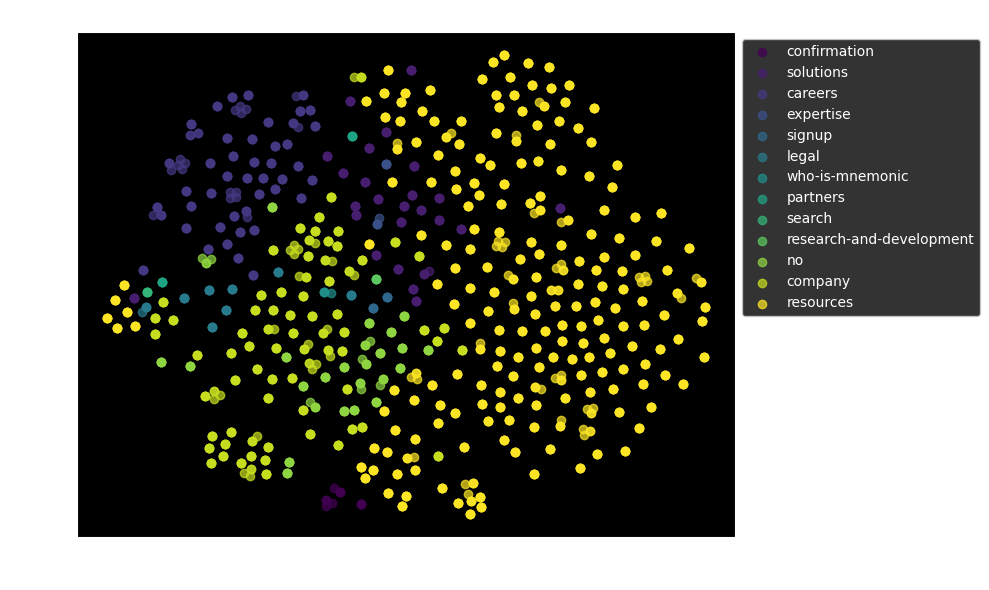

In [13]:
# Plot
unique_categories = list(set(categories))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_categories)))
category_to_color = dict(zip(unique_categories, colors))

plt.figure(figsize=(10, 6))  
plt.style.use('dark_background')


for category, color in category_to_color.items():
    indices = [i for i, x in enumerate(categories) if x == category]
    plt.scatter(data_2d[indices, 0], data_2d[indices, 1], label=category, color=color, alpha=0.7)


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D visualization with Categories')

plt.tight_layout()

plt.show()

In [14]:
for i in docs:
    i.metadata['lenght'] = len(i.page_content)

In [15]:
lengths = [i.metadata['lenght'] for i in docs]

(array([ 57., 110.,  71.,  36.,  44.,  25.,  13.,   9.,   2.,   2.,   1.,
          3.,   3.,   2.,   2.,   2.,   3.,   0.,   2.,   2.,   2.,   1.,
          1.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  138.  ,   647.58,  1157.16,  1666.74,  2176.32,  2685.9 ,
         3195.48,  3705.06,  4214.64,  4724.22,  5233.8 ,  5743.38,
         6252.96,  6762.54,  7272.12,  7781.7 ,  8291.28,  8800.86,
         9310.44,  9820.02, 10329.6 , 10839.18, 11348.76, 11858.34,
        12367.92, 12877.5 , 13387.08, 13896.66, 14406.24, 14915.82,
        15425.4 , 15934.98, 16444.56, 16954.14, 17463.72, 17973.3 ,
        18482.88, 18992.46, 19502.04, 20011.62, 20521.2 , 21030.78,
        21540.36, 22049.94, 22559.52, 23069.1 , 23578.68, 24088.26,
        24597.84, 25107.42, 25617.  ]),
 <BarContainer object of 50 artists>)

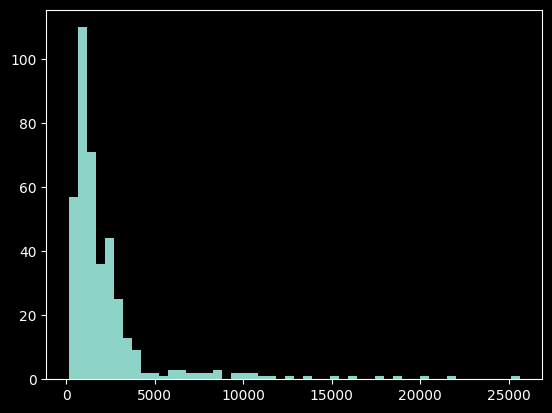

In [16]:
plt.hist(lengths, bins=50)

In [17]:
metadatas = mnemonic_db._collection.get(include=["metadatas"])['metadatas']

display(metadatas[0])

{'category': 'resources',
 'source': 'https://www.mnemonic.io/resources/podcast/episode-4-under-the-hood-of-argus/',
 'subcategory': 'podcast',
 'title': 'Episode 4: Under the hood of Argus'}

In [18]:
# convert to dataframe
import pandas as pd

df = pd.DataFrame(metadatas)

C:\Users\fredr\AppData\Local\Temp\ipykernel_27984\2471556548.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [19]:
df.value_counts('category')

category
resources                   836
company                     300
careers                     192
no                          100
solutions                   100
legal                        32
confirmation                 12
expertise                     8
partners                      8
signup                        8
research-and-development      4
search                        4
who-is-mnemonic               4
Name: count, dtype: int64

In [20]:
df.loc[df['category'] == 'solutions'].value_counts('subcategory')

subcategory
partnerships-our-technology-vendors    16
incident-response                      12
                                        4
our-technology-vendors                  4
threat-intelligence                     4
secure-dns                              4
secure-code-training-for-developers     4
risk-assessment                         4
red-teaming-and-tiber                   4
penetration-testing                     4
managed-security-and-support            4
application-security-testing            4
managed-detection-and-response          4
enterprise-security-architecture        4
consulting                              4
compliance-and-regulatory               4
cloud-security-assessment               4
ciso-for-hire                           4
assessment-and-testing                  4
vulnerability-monitoring                4
Name: count, dtype: int64

In [21]:
df.loc[df['subcategory'] == 'threat-intelligence']

,category,source,subcategory,title
34,solutions,https://www.mnemonic.io/solutions/threat-intel...,threat-intelligence,Threat Intelligence
436,solutions,https://www.mnemonic.io/solutions/threat-intel...,threat-intelligence,Threat Intelligence
838,solutions,https://www.mnemonic.io/solutions/threat-intel...,threat-intelligence,Threat Intelligence
1240,solutions,https://www.mnemonic.io/solutions/threat-intel...,threat-intelligence,Threat Intelligence
